## Transformer Training

Alex McDonald

In this jupyter notebook we will load the vocab and examples, then train transformer models on the spam and phishing URL examples. We will be using the GLoVE pre-trained embeddings, mostly to cut down on the amount of training needed for the rest of the transformer. 

In [1]:
import torch, torch.nn as nn
import numpy as np
import pandas as pd
import nltk
import math
import matplotlib.pyplot as plt

In [2]:
#Load the vocabulary space, adapted from Homework 2
glove_file = "./datasets/glove.6B.100d.txt" #or 50d

embeddings_dict = {}

with open(glove_file, 'r', encoding='utf8') as f:
    for i, line in enumerate(f):
        if i == 0:
            print(line)
        line = line.strip().split(' ')
        word = line[0]
        embed = np.asarray(line[1:], "float")

        embeddings_dict[word] = embed

print('Loaded {} words from glove'.format(len(embeddings_dict)))

embedding_matrix = np.zeros((len(embeddings_dict)+2, 100)) #add 1 for padding

word2id = {}
for i, word in enumerate(embeddings_dict.keys()):

    word2id[word] = i                                #Map each word to an index
    embedding_matrix[i] = embeddings_dict[word]      #That index holds the Glove embedding in the embedding matrix

# Our joint vocabulary for both models / sanity check to see if we've loaded it correctly:
print(word2id['the'])
print(embedding_matrix[word2id['the']])

word2id['<pad>'] = embedding_matrix.shape[0] - 2
word2id['<start>'] = embedding_matrix.shape[0] - 1
print(embedding_matrix[word2id['<pad>']])

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062

Loaded 400000 words from glove
0
[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0

Out of curiosity, here I'm checking whether Glove has embeddings for common components of URLs. If so, we can possibly consider it as part of the URLs model.

In [4]:
def embedding_exists(s):
    if not (s in word2id): return False
    if not (word2id[s] in embedding_matrix): return False
    return True

test_tokens = ["http", "https", ".com", "com", ".org", "org", ".net", "net"] #can add more, but likely that <unk> token will be frequent in the URL model
found = []
not_found = []
for token in test_tokens:
    if (embedding_exists(token)): 
        found.append(token)
    else: 
        not_found.append(token)

print("Found tokens %s" % found)
print("Could not find %s" % not_found)
        

Found tokens []
Could not find ['http', 'https', '.com', 'com', '.org', 'org', '.net', 'net']


It looks like there does not exist common url components in the Glove embeddings, so we will need to likely train our own embeddings for the URL model. This might give the model an advantage though, because patterns like "http" vs. "https" might help the model distinguish between different url types. Given how many different combinations of URLs can exist though (such as two words put together without any hyphenation) may still lead to a large number of $<unk>$ tokens, which will be another problem to address.

However, the GloVE embeddings should be adequate for the spam detection model. We will still need to be careful though, because the glove embeddings carry some amount of bias with them, which may become amplified by the model.

To save on computational resources, we will start with a smaller subset of the data, then increase it for the final training. Let's load the spam datasets:

In [ ]:
spam_full = pd.read_csv("./datasets/SpamHam/train.csv")#, nrows=20000)

split_ratio = 0.8
train_size = int(split_ratio*spam_full.shape[0])
spam_train = spam_full.iloc[:train_size]
spam_valid = spam_full.iloc[train_size:]
max_length = 120 #inclusive of start token
'''
train_size_url = int(split_ratio*urls_full.shape[0])
urls_train = urls_full.iloc[:train_size]
urls_valid = urls_full.iloc[train_size:]
url_max_length = 120
'''
start_id = word2id['<start>']

def tokenize_example(line):
    example = [start_id]
    tokenized = nltk.word_tokenize(line)
    i = 0
    for token in tokenized:
        if not (token in word2id): continue #not using <unk> for spam dataset
        i += 1
        if (i >= max_length): break
        example.append(word2id[token])
        
    #add padding
    padding = word2id["<pad>"]
    for i in range(max_length - len(example)):
        example.append(padding)
    return np.array(example)

def tokenize(df):
    examples = []
    for index, row in df.iterrows():
        example = tokenize_example(row["text"])
        if (len(example) > 0 and len(example.shape) > 0): examples.append((example, row["label"]))
    return examples

tokenized_spam_train = tokenize(spam_train)
tokenized_spam_valid = tokenize(spam_valid)

Here we will create a simple pytorch transformer. Because the model will only be doing binary classification and we are limited in our computing power, we will use a relatively small transformer that uses far fewer parameters than a typical transformer like BERT. We will start with an encoder model, but if it performs poorly we can try a decoder model.

In [3]:
class TransformerModel(nn.Module):

    def __init__(self, embedding_matrix, model_size, n_heads, n_layers, hidden_size, embedding_dims=100, vocab_size=None):
        super().__init__()

        if not (embedding_matrix is None): #glove
            self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dims)
        self.pos_encoding = PositionalEncoding(embedding_dims, max_length)
        self.input_linear = nn.Linear(embedding_dims, model_size)
        encoder_layers = nn.TransformerEncoderLayer(model_size, n_heads, hidden_size, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layers, n_layers)
        self.output_hidden_1 = nn.Linear(model_size, hidden_size)
        self.relu = nn.ReLU()
        self.output_hidden_2 = nn.Linear(hidden_size, 2) #binary classification
        self.model_size = model_size

        #initialize layers
        initrange = 0.1
        self.input_linear.weight.data.uniform_(-initrange, initrange)
        self.input_linear.bias.data.zero_()
        self.output_hidden_1.weight.data.uniform_(-initrange, initrange)
        self.output_hidden_1.bias.data.zero_()
        self.output_hidden_2.weight.data.uniform_(-initrange, initrange)
        self.output_hidden_2.bias.data.zero_()

    def forward(self, input):

        input = (self.embedding(input) * math.sqrt(self.model_size)) #recommended from documentation
        input = self.pos_encoding(input)
        input = self.input_linear(input) #get a representation that has the model size for the positionally encoded embeddings
        
        output = self.encoder(input)[:,0] #take the last vector
        output = self.output_hidden_1(output)
        output = self.relu(output)
        output = self.output_hidden_2(output)

        return output

class PositionalEncoding(nn.Module):

    def __init__(self, model_size, max_len): #from torch documentation
        super().__init__()
        self.dropout = nn.Dropout(p=0.1)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, model_size, 2) * (-math.log(10000.0) / model_size))
        pe = torch.zeros(max_len, 1, model_size)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

Here we will define our hyperparameters:

In [ ]:
epochs = 6
batch_size = 32
print_frequency = 250
n_heads = 2
n_layers = 2
model_size = 28
hidden_size = 48
pos_weight_coeff = 1.05 # >1 increases recall, <1 increases precision

spam_model = TransformerModel(embedding_matrix, model_size=model_size, n_heads=n_heads, n_layers=n_layers, hidden_size=hidden_size)

import copy
criteria = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight_coeff]))
optimizer = torch.optim.AdamW(spam_model.parameters(), lr=0.001)

Here we will define our training loop:

In [4]:

def training_loop(model, dataloader):
    one_hot = torch.tensor(np.array([[1, 0], [0, 1]]), dtype=torch.float)
    losses = []
    lowest_loss = 1e5
    best_model_sd = None
    
    for i in range(epochs):
        print("--- Epoch %s --- " % (i+1))
    
        model.train()
        avg_loss = 0
    
        for step, data in enumerate(dataloader):
            x,y = data
            x = x.squeeze()
            if (len(x.shape) == 0): continue
            optimizer.zero_grad()
    
            output = model(x)
            loss = criteria(output, one_hot[y])
    
            loss.backward()
            optimizer.step()
    
            avg_loss += loss.item()
    
            if step % print_frequency == 1 and step > 1:
                losses.append(avg_loss / print_frequency)
                #print(output, one_hot[y])
                avg_loss /= print_frequency
                print('epoch: {} batch: {} loss: {}'.format(
                    i,
                    step,
                    avg_loss
                ))
                if (avg_loss < lowest_loss):
                    lowest_loss = avg_loss
                    best_model_sd = copy.deepcopy(model.state_dict())
                
                avg_loss = 0
    
    plt.plot(losses)
    plt.xlabel("Step (Print frequency %s)" % print_frequency)
    plt.ylabel("Loss")
    plt.title("Loss vs. Step #")
    plt.show()

    return [model, best_model_sd]


And finally, we will put this all together to train the model on the spam dataset. Shown below is the loss curve as a function of step number.

--- Epoch 1 --- 
epoch: 0 batch: 251 loss: 0.4593024874031544
epoch: 0 batch: 501 loss: 0.2759305145144463
epoch: 0 batch: 751 loss: 0.2719428166747093
epoch: 0 batch: 1001 loss: 0.24769739328324794
epoch: 0 batch: 1251 loss: 0.2386951026916504
epoch: 0 batch: 1501 loss: 0.22729503881931304
epoch: 0 batch: 1751 loss: 0.23034461492300035
epoch: 0 batch: 2001 loss: 0.2067235134616494
epoch: 0 batch: 2251 loss: 0.22102808628976345
epoch: 0 batch: 2501 loss: 0.20482587586343287
epoch: 0 batch: 2751 loss: 0.19655827356874941
epoch: 0 batch: 3001 loss: 0.1973212195634842
epoch: 0 batch: 3251 loss: 0.19699283502995968
--- Epoch 2 --- 
epoch: 1 batch: 251 loss: 0.18825771906226874
epoch: 1 batch: 501 loss: 0.18078761412203312
epoch: 1 batch: 751 loss: 0.17484294582903384
epoch: 1 batch: 1001 loss: 0.17049027483165263
epoch: 1 batch: 1251 loss: 0.17678494935482741
epoch: 1 batch: 1501 loss: 0.18349862195551395
epoch: 1 batch: 1751 loss: 0.1709393737912178
epoch: 1 batch: 2001 loss: 0.1574025682

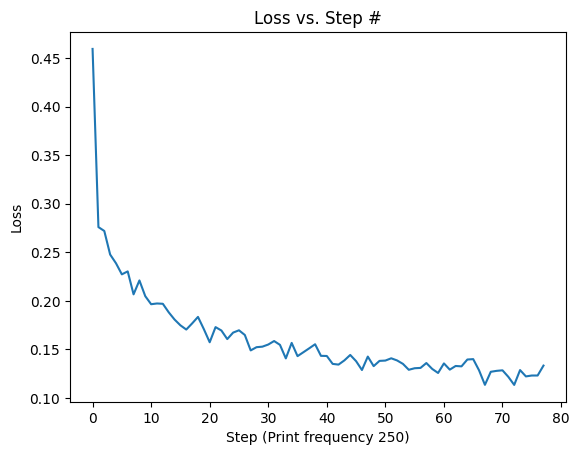

In [19]:

spam_train_dataloader = torch.utils.data.DataLoader(tokenized_spam_train, batch_size=batch_size)

spam_model, best_model_sd = training_loop(spam_model, spam_train_dataloader)

best_model = TransformerModel(embedding_matrix, model_size=model_size, n_heads=n_heads, n_layers=n_layers, hidden_size=hidden_size)
best_model.load_state_dict(best_model_sd)

Next we will define a function to measure the performance of the model. I've implemented this to measure precision and recall so that we can also calculate F1 score. It will also have to do the softmax on the output itself, since we used BCE Loss with Logits originally.

In [5]:
def predict(model, valid_dataloader):

    softmax = nn.Softmax()

    model.eval()
    
    sigmoid = nn.Sigmoid()

    total_examples = 0
    total_positive = 0
    total_negative = 0

    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0

    for x, y in valid_dataloader:
        x = x.squeeze()
        if (len(x.shape) == 0): continue
        output = model(x)
        output = softmax(output)

        for i in range(output.shape[0]):
            if (output[i][0].item() >= 0.5):
                if (y[i].item() == 0):
                    true_negative += 1
                    total_negative += 1
                else:
                    false_negative += 1
                    total_positive += 1
            else:
                if (y[i].item() == 0):
                    false_positive += 1
                    total_negative += 1
                else:
                    true_positive += 1
                    total_positive += 1
        total_examples += output.shape[0]
        #print("total examples:", total_examples, "; T+:", true_positive, "; F+:", false_positive, "; T-:", true_negative, "; F-:", false_negative)

    accuracy = (true_positive + true_negative) / total_examples
    t_p = true_positive/total_examples
    f_p = false_positive/total_examples
    t_n = true_negative/total_examples
    f_n = false_negative/total_examples
    p = true_positive/(true_positive + false_positive)
    r = true_positive/(true_positive + false_negative)
    f_score = (2*p*r)/(p+r)

    print('accuracy: %s/%s = %s' % (true_positive+true_negative, total_examples, (true_positive + true_negative) / total_examples))
    print('True positive: %s' % t_p)
    print("False positive: %s" % f_p)
    print('True negative: %s' % t_n)
    print("False negative: %s" % f_n)
    print("(P, R, F-Score) = (%s, %s, %s)\n" % (p, r, f_score))
    return accuracy

In [21]:

spam_valid_dataloader = torch.utils.data.DataLoader(tokenized_spam_valid, batch_size=batch_size)
print("BEST MODEL:")
predict(best_model, spam_valid_dataloader)
print("LAST MODEL:")
predict(spam_model, spam_valid_dataloader)


BEST MODEL:


/home/ubuntu/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


accuracy: 26104/27139 = 0.9618630015844357
True positive: 0.45325914735251854
False positive: 0.022403183610302517
True negative: 0.5086038542319171
False negative: 0.0157338148052618
(P, R, F-Score) = (0.9529010767681463, 0.9664519170333123, 0.9596286616998869)

LAST MODEL:
accuracy: 26118/27139 = 0.962378864364936
True positive: 0.4499428866207303
False positive: 0.018571060098013927
True negative: 0.5124359777442058
False negative: 0.01905007553705
(P, R, F-Score) = (0.9603617774282344, 0.9593808925204274, 0.9598710843847031)



0.962378864364936

# Validation Set Results

With these hyperparameters, the best model was able to achieve almost 96% accuracy on the validation set! Also, the false negative rate is lower than the false positive rate. This is good because the model's loss function will focus more on recall, as there is more danger with a malicious email that is not filtered than a safe email that is falsely labeled as spam. The F1 score is also well above our acceptable cutoff of 0.7.

Lastly, we will save the best model's state dictionary:


In [23]:
torch.save(best_model_sd, "./trained_models/spam.pt")
torch.save(spam_model.state_dict(), "./trained_models/spam_last.pt")

# URLs Dataset

The 2nd part of the model will be a transformer very similar to the spam transformer, although the key difference is in the embedding layer. There are several options for how to tokenize URLs. We can't use the Glove embeddings however, because there is not necessarily a delimiter for a URL that we could split into individual words. The naive approach would be to separate by punctuation, such as "/" or "-", but there could still be punctuation not accounted for, or concatenated words in any part of the URL. Thus, we will start with character embeddings. In the future, we could investigate with using another tokenizer (such as from BERT or OpenAI) that does sub-word tokenization, or investigate whether nltk can accurately split concatenated words into separate tokens.

First, we will load and tokenize the dataset:

In [67]:
urls_full = pd.read_csv('./datasets/PhishingURLs/train.csv')

#Data preprocessing, from data_stats.ipynb
urls_full = urls_full.dropna()
possible_labels = urls_full["label"].unique()
urls_full["label"] = urls_full["label"].apply(lambda x: 2 - x) #1=phishing

urls_full.head()

,label,text
0,0,https://blog.sockpuppet.us/
1,0,https://blog.apiki.com/seguranca/
2,1,http://autoecole-lauriston.com/a/T0RVd056QXlNe...
3,1,http://chinpay.site/index.html?hgcFSE@E$Z*DFcG...
4,0,http://www.firstfivenebraska.org/blog/article/...


In [68]:
#Split into train and validate sets
split_ratio = 0.8
train_size = int(split_ratio*urls_full.shape[0])
urls_train = urls_full.iloc[:train_size]
urls_valid = urls_full.iloc[train_size:]
max_length = 120

In [69]:

#our vocab is small enough that it can be written out manually.
alphabet = 'abcdefghijklmnopqrstuvwxyz1234567890./-:@&?'
vocab = {'<start>': 0, '<pad>': 1, '<unk>': 2} #special tokens
num_special_tokens = len(vocab)
for i in range(len(alphabet)):
    vocab[alphabet[i]] = i + num_special_tokens
print("Vocab:")
print(vocab)

def tokenize_url_example(example):
    tokenized = [vocab["<start>"]]
    padding = vocab['<pad>']
    unk = vocab['<unk>']
    
    for i in range(min(len(example), max_length-1)):
        char = example[i]
        if not char in vocab: tokenized.append(unk)
        else: tokenized.append(vocab[char])
    tokenized += [padding]*(max_length - len(example) - 1)
    return np.array(tokenized)

print("Testing:")
token_test = tokenize_url_example("!https://abc.xyz")
print("Size %s, %s" % (len(token_test), token_test))


Vocab:
{'<start>': 0, '<pad>': 1, '<unk>': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'y': 27, 'z': 28, '1': 29, '2': 30, '3': 31, '4': 32, '5': 33, '6': 34, '7': 35, '8': 36, '9': 37, '0': 38, '.': 39, '/': 40, '-': 41, ':': 42, '@': 43, '&': 44, '?': 45}
Testing:
Size 120, [ 0  2 10 22 22 18 21 42 40 40  3  4  5 39 26 27 28  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]


In [70]:
#Tokenize the examples
def tokenize_urls(df):
    examples = []
    for index, row in df.iterrows():
        examples.append((tokenize_url_example(row["text"]), row["label"]))
    return examples

tokenized_url_train = tokenize_urls(urls_train)
tokenized_url_valid = tokenize_urls(urls_valid)

print(tokenized_url_train[:3]) # :3

[(array([ 0, 10, 22, 22, 18, 21, 42, 40, 40,  4, 14, 17,  9, 39, 21, 17,  5,
       13, 18, 23, 18, 18,  7, 22, 39, 23, 21, 40,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1]), 0), (array([ 0, 10, 22, 22, 18, 21, 42, 40, 40,  4, 14, 17,  9, 39,  3, 18, 11,
       13, 11, 39,  5, 17, 15, 40, 21,  7,  9, 23, 20,  3, 16,  5,  3, 40,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
     

We will now define the hyperparameters and run the training loop. The transformer model from last time can be used, as we've added functionality to either use the pretrained Glove embeddings or train our own embedding space.

In [78]:
epochs = 3
batch_size = 32
print_frequency = 600
n_heads = 2
n_layers = 2
model_size = 50
hidden_size = 50
pos_weight_coeff = 1.05 # >1 increases recall, <1 increases precision
embedding_dims = 32

url_model = TransformerModel(None, model_size=model_size, n_heads=n_heads, 
                             n_layers=n_layers, hidden_size=hidden_size, vocab_size=len(vocab), embedding_dims=embedding_dims)

import copy

criteria = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight_coeff]))
optimizer = torch.optim.AdamW(url_model.parameters(), lr=0.0005)


We can now train the model using the same training loop as before:

--- Epoch 1 --- 
epoch: 0 batch: 601 loss: 0.5540482880671819
epoch: 0 batch: 1201 loss: 0.4835406631231308
epoch: 0 batch: 1801 loss: 0.4607098144541184
epoch: 0 batch: 2401 loss: 0.4431217308839162
epoch: 0 batch: 3001 loss: 0.4363610397527615
epoch: 0 batch: 3601 loss: 0.43221483898659546
epoch: 0 batch: 4201 loss: 0.4257178757588069
epoch: 0 batch: 4801 loss: 0.42305396022895975
epoch: 0 batch: 5401 loss: 0.4176707290112972
epoch: 0 batch: 6001 loss: 0.4125577887892723
epoch: 0 batch: 6601 loss: 0.40645013759533566
epoch: 0 batch: 7201 loss: 0.417993732864658
epoch: 0 batch: 7801 loss: 0.41040833204984667
epoch: 0 batch: 8401 loss: 0.40562988189359506
epoch: 0 batch: 9001 loss: 0.409632176309824
epoch: 0 batch: 9601 loss: 0.4101736369480689
epoch: 0 batch: 10201 loss: 0.4072177118311326
epoch: 0 batch: 10801 loss: 0.4055121047794819
epoch: 0 batch: 11401 loss: 0.40828522115945814
epoch: 0 batch: 12001 loss: 0.4047678255289793
epoch: 0 batch: 12601 loss: 0.3967386864622434
epoch: 0 

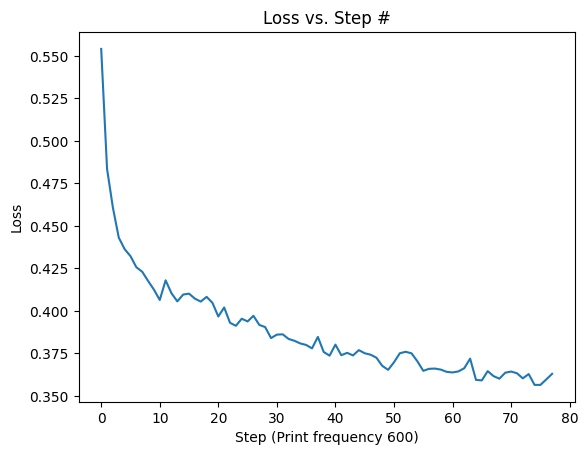

<All keys matched successfully>

In [79]:
url_train_dataloader = torch.utils.data.DataLoader(tokenized_url_train, batch_size=batch_size)

url_model, best_url_model_sd = training_loop(url_model, url_train_dataloader)

best_url_model = TransformerModel(None, model_size=model_size, n_heads=n_heads, n_layers=n_layers, hidden_size=hidden_size, vocab_size=len(vocab), embedding_dims=embedding_dims)
best_url_model.load_state_dict(best_url_model_sd)

In [81]:
best_url_model = TransformerModel(None, model_size=model_size, n_heads=n_heads, n_layers=n_layers, hidden_size=hidden_size, vocab_size=len(vocab), embedding_dims=embedding_dims)
best_url_model.load_state_dict(best_url_model_sd)

urls_valid_dataloader = torch.utils.data.DataLoader(tokenized_url_valid, batch_size=batch_size)

print("BEST MODEL:")
predict(best_url_model, urls_valid_dataloader)
print("LAST MODEL:")
predict(url_model, urls_valid_dataloader)


BEST MODEL:


/home/ubuntu/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


accuracy: 109372/128000 = 0.85446875
True positive: 0.4227421875
False positive: 0.06946875
True negative: 0.4317265625
False negative: 0.0760625
(P, R, F-Score) = (0.8588638636255417, 0.8475104546807211, 0.8531493890421759)

LAST MODEL:
accuracy: 110385/128000 = 0.8623828125
True positive: 0.4255625
False positive: 0.064375
True negative: 0.4368203125
False negative: 0.0732421875
(P, R, F-Score) = (0.8686056895012119, 0.8531645966137799, 0.8608159040447538)



0.8623828125

In [83]:
torch.save(best_url_model_sd, './trained_models/url_best.pt')
torch.save(url_model.state_dict(), './trained_models/url.pt')

We can likely improve the URL transformer's results by changing how it is tokenized. With future work, we could use another tokenization method, such as sub-word tokenization that can tokenize chunks of the word. Tokenizing the URLs is particularily challenging because there is no obvious delimeter. If we split the example string by punctuation such as slashes or periods, we might have a large number of $<unk>$ tokens, even with legimate URLs because of compound words in domain names. The model does not need to learn the definitions of the tokens, either. So, in practice, it might make more sense to have a list of safe URLs (such as "chase.com" or "google.com"), and have a simpler model used in detecting if one URL is attempting to mimick a safe url. This could be done with something as simple as a rule-based model to get the differences between 2 strings. Another way is to have a system in place for users to report unsafe URLs.

# Test Set

We will now evaluate the models on the testing sets.

In [16]:
spam_test = pd.read_csv("./datasets/SpamHam/test.csv")

start_id = word2id['<start>']

tokenized_spam_test = tokenize(spam_test)

In [19]:
#Load the hyperparameters from the original spam model
epochs = 6
batch_size = 32
print_frequency = 250
n_heads = 2
n_layers = 2
model_size = 28
hidden_size = 48
pos_weight_coeff = 1.05 # >1 increases recall, <1 increases precision

spam_model = TransformerModel(embedding_matrix, model_size=model_size, n_heads=n_heads, n_layers=n_layers, hidden_size=hidden_size)
spam_model.load_state_dict(torch.load('./trained_models/spam.pt'))

<All keys matched successfully>

We will now run the predict function on the test set and measure its F1 score.

In [20]:
spam_test_dataloader = torch.utils.data.DataLoader(tokenized_spam_test, batch_size=batch_size)

predict(spam_model, spam_test_dataloader)

/home/ubuntu/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


accuracy: 55864/58155 = 0.9606052789957871
True positive: 0.46097498065514575
False positive: 0.02393603301521795
True negative: 0.4996302983406414
False negative: 0.015458687988994928
(P, R, F-Score) = (0.9506382978723404, 0.9675533258743277, 0.9590212316883394)



0.9606052789957871

The test set results are very similar to the validation set! It is also good that the false negative rate continues to be lower than the false positive rate (although noteably, there is still some randomness to this).

## URLs Test Set

This is a similar process to the spam dataset.

In [86]:
urls_test = pd.read_csv('./datasets/PhishingURLs/test.csv')

#Data preprocessing, from data_stats.ipynb
urls_test = urls_test.dropna()
urls_test["label"] = urls_test["label"].apply(lambda x: 2 - x) #1=phishing

urls_test.head()

,label,text
0,0,http://minsotc.alania.gov.ru
1,0,http://www.freejavaguide.com
2,1,http://yeneliswa.co.za/moods/bankofamerica/7dd...
3,0,https://victordahdalehfoundation.com/programme...
4,0,http://camphhsi.com/product/list_947.html


In [87]:
tokenized_url_test = tokenize_urls(urls_test)

url_test_dataloader = torch.utils.data.DataLoader(tokenized_url_test, batch_size=batch_size)

predict(url_model, url_test_dataloader)

/home/ubuntu/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


accuracy: 137820/160000 = 0.861375
True positive: 0.42650625
False positive: 0.06513125
True negative: 0.43486875
False negative: 0.07349375
(P, R, F-Score) = (0.867521802140805, 0.8530125, 0.8602059724445676)



0.861375